# Global map of drag coefficient (SAH: 0.1-deg vs. SYNBATH topography)

In [1]:
%matplotlib inline
import numpy as np
import xesmf as xe
import xarray as xr
import netCDF4 as nc
import cmocean as cm
import matplotlib.ticker
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from dask.distributed import Client
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec
from scipy.interpolate import griddata
from gsw import f, Nsquared, p_from_z, z_from_p
  
import warnings
warnings.filterwarnings('ignore')

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 18.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41957,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 18.00 GiB
Comm: tcp://127.0.0.1:46495,Total threads: 1
Dashboard: /proxy/42157/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:43183,


In [3]:
data_01 = xr.open_dataset('/g/data/nm03/lxy581/global_drag_coeff/sigma_SAH_M2_01_2d_global.nc')
data_m2 = xr.open_dataset('/g/data/nm03/lxy581/global_drag_coeff/sigma_SAH_M2_2d_global.nc')
sigma_mag_01 = data_01.sigma_mag
sigma_mag_m2 = data_m2.sigma_mag
sigma_xy_01 = data_01.sigma_xy
sigma_xy_m2 = data_m2.sigma_xy

sigma_mag_diff = sigma_mag_m2 - sigma_mag_01
sigma_xy_diff = sigma_xy_m2 - sigma_xy_01

###  Global mean of the ratio of difference in (modulus of) the drag coeff to high-res drag coeff: 36%

In [4]:
np.nanmean(sigma_mag_diff/sigma_mag_m2)

0.3552816554994096

## Ocean depth

In [5]:
topog = xr.open_dataset('/home/581/lxy581/tidal_param/MOM6-examples/ocean_only/tides_025/INPUT/ocean_topog.nc')
depth = topog.depth
depth_z = np.array(depth)
depth_z[depth_z==0]=np.nan
grid_JSL = xr.open_dataset('/g/data/nm03/lxy581/archive/tides_025_JSL/output012/ocean_static.nc')
lon = np.array(grid_JSL['geolon'])
lat = np.array(grid_JSL['geolat'])
yh, xh = grid_JSL.yh, grid_JSL.xh
depth_da = xr.Dataset(data_vars={'depth_xr': (('yh','xh'), depth_z),
                                }, 
                      coords={'lon': (('yh', 'xh'), lon),
                              'lat': (('yh', 'xh'), lat)})
land = xr.where(np.isnan(depth_da.depth_xr[:,:].rename('land')), 1, np.nan)

## Plot drag coefficient

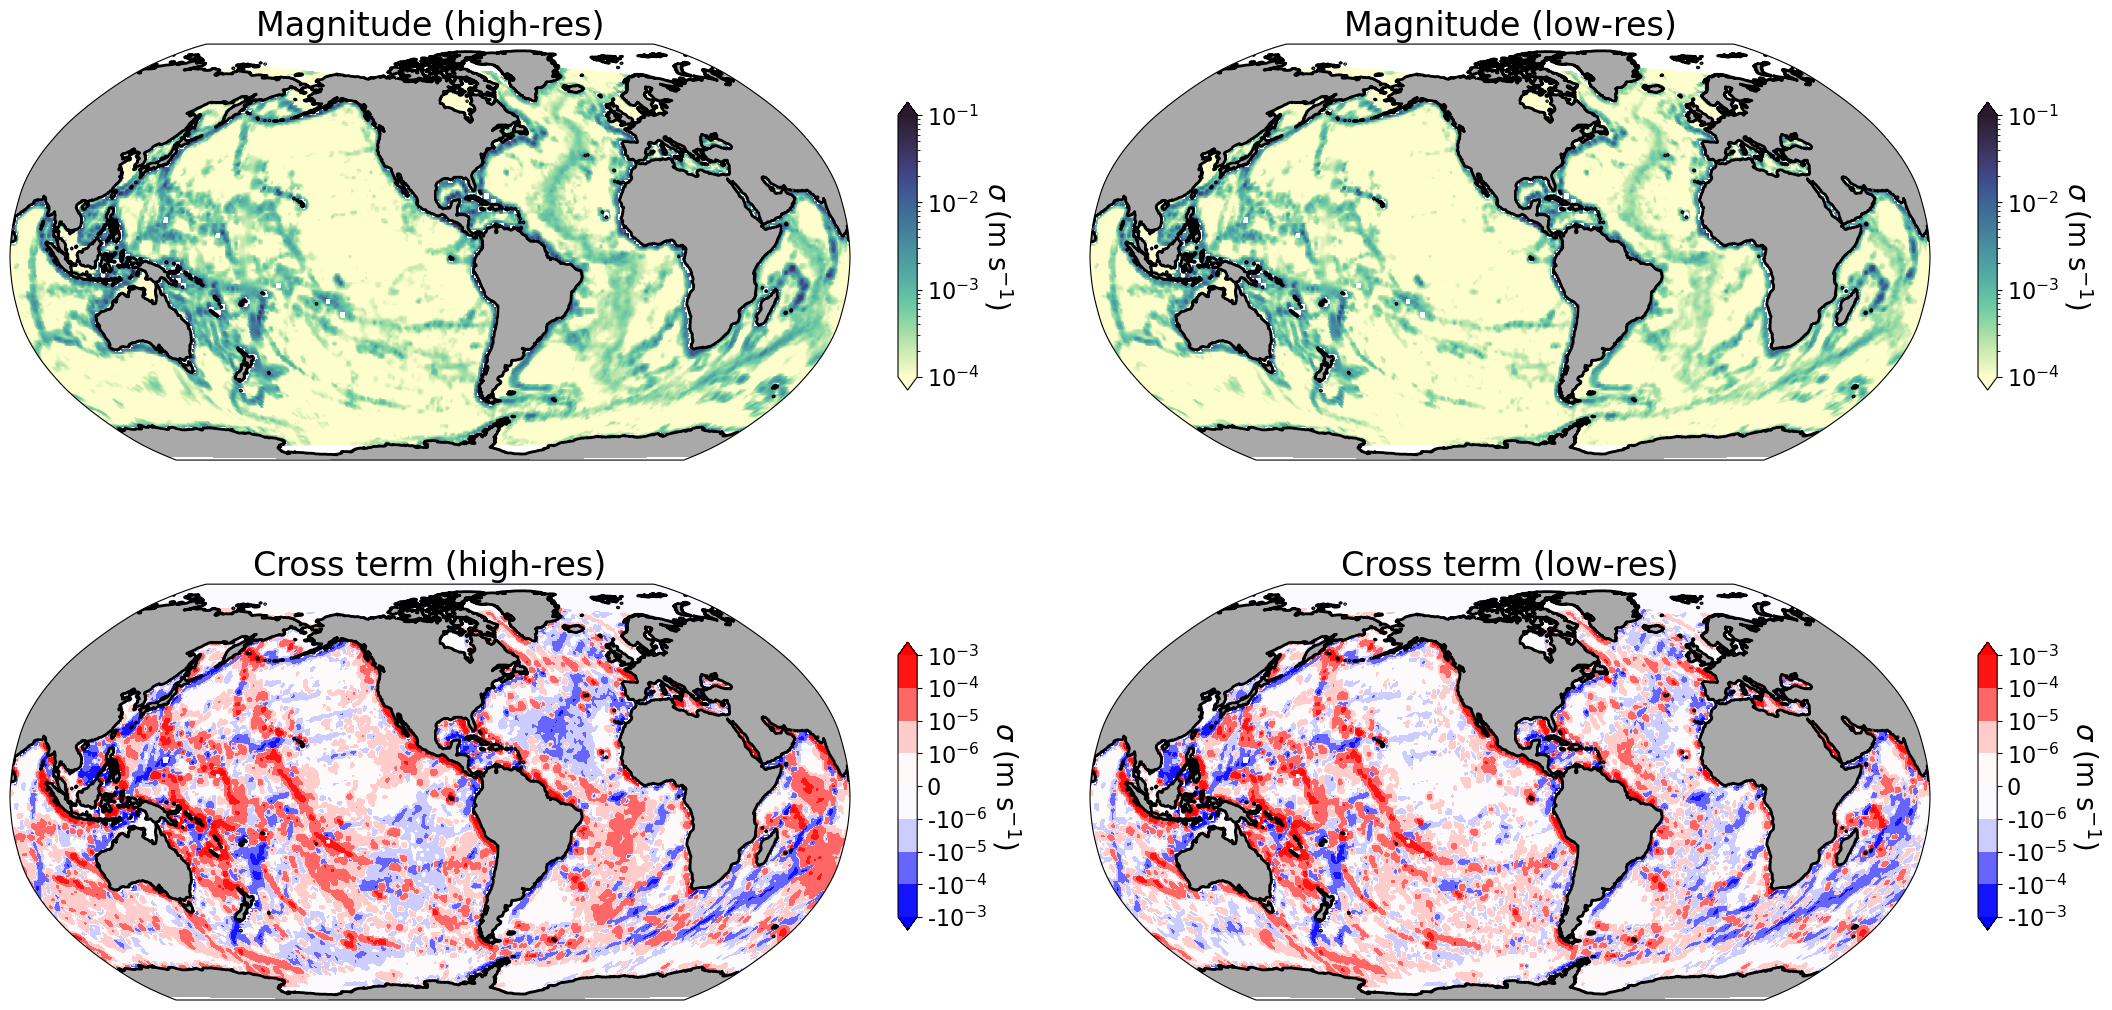

In [6]:
# title = ['Magnitude (high-res)','Magnitude (high - low)','Cross term (high-res)','Cross term (high - low)']
# varls = ['sigma_mag_m2','sigma_mag_diff','sigma_xy_m2','sigma_xy_diff']
title = ['Magnitude (high-res)','Magnitude (low-res)','Cross term (high-res)','Cross term (low-res)']
varls = ['sigma_mag_m2','sigma_mag_01','sigma_xy_m2','sigma_xy_01']

half_pos = np.logspace(-6,-3,4)
half_mid = np.array([0])
half_neg = -half_pos[::-1]
diff_lev = np.concatenate([half_neg,half_mid,half_pos])

fig = plt.figure(figsize=(24, 12))
axs = []

gridsubs = gridspec.GridSpec(2,2)
for gs in gridsubs:
    axs.append(plt.subplot(gs))

for I, (ax, var) in enumerate(zip(axs, varls)):

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

    ax = plt.axes(projection=ccrs.Robinson(central_longitude=-100))
    # Add model land mask
    land.plot.contourf(ax=ax, x='lon', y='lat', colors='darkgrey', zorder=2, transform=ccrs.PlateCarree(), add_colorbar=False)
    # Add model coastline
    land.fillna(0).plot.contour(ax=ax, x='lon', y='lat', colors='k', levels=[0, 1], transform=ccrs.PlateCarree(), add_colorbar=False, linewidths=2.0)

    if I<2:
        p1 = ax.pcolormesh(lon, lat, globals()[var], transform=ccrs.PlateCarree(), cmap=cm.cm.deep, norm=LogNorm(vmin=1e-4, vmax=1e-1))
    if I>1:
        # p1 = ax.pcolormesh(lon, lat, globals()[var], transform=ccrs.PlateCarree(), cmap=cm.cm.deep, norm=LogNorm(vmin=1e-6, vmax=1e-3))
        p1 = ax.contourf(lon, lat, globals()[var], levels = diff_lev, transform=ccrs.PlateCarree(), cmap = 'bwr', norm=colors.SymLogNorm(linthresh=1e-5,linscale=1,vmin=-1e-3,vmax=1e-3,base=10), extend='both')
    plt.title(title[I],fontsize=24)
  
    if I==0:
        ax_cb = plt.axes([0.47, 0.61, 0.008, 0.24])
    if I==1:
        ax_cb = plt.axes([0.92, 0.61, 0.008, 0.24])
    if I==2:
        ax_cb = plt.axes([0.47, 0.16, 0.008, 0.24])
    if I==3:
        ax_cb = plt.axes([0.92, 0.16, 0.008, 0.24])
        
    if I<2:        
        cb1 = plt.colorbar(p1, cax=ax_cb, orientation='vertical', extend='both')
        cb1.ax.set_ylabel(r'$\sigma$ (m s$^{-1}$)',fontsize=20,rotation=270,labelpad=25);
        cb1.ax.tick_params(labelsize=16)
    if I>1:   
        cb1 = plt.colorbar(p1, cax=ax_cb, orientation='vertical', extend='both')
        cb1.ax.set_ylabel(r'$\sigma$ (m s$^{-1}$)',fontsize=20,rotation=270,labelpad=25);
        cb1.ax.tick_params(labelsize=16)
        tick_locs   = np.array([-1e-3,-1e-4,-1e-5,-1e-6,0,1e-6,1e-5,1e-4,1e-3])
        tick_labels = np.array(['-10$^{-3}$','-10$^{-4}$','-10$^{-5}$','-10$^{-6}$','0','10$^{-6}$','10$^{-5}$','10$^{-4}$','10$^{-3}$'])
        cb1.locator   = matplotlib.ticker.FixedLocator(tick_locs)
        cb1.formatter = matplotlib.ticker.FixedFormatter(tick_labels)
        
    if I==0:
        ax.set_position([0.1,0.55,0.35,0.35])
    if I==1:
        ax.set_position([0.55,0.55,0.35,0.35])
    if I==2:
        ax.set_position([0.1,0.1,0.35,0.35])
    if I==3:
        ax.set_position([0.55,0.1,0.35,0.35])
      
# plt.savefig('/g/data/nm03/lxy581/global_drag_coeff/drag_coeff_SAH_M2_01topog_025_diff.png', dpi=100, bbox_inches='tight')  
plt.savefig('/g/data/nm03/lxy581/global_drag_coeff/drag_coeff_SAH_M2_01topog_025.png', dpi=100, bbox_inches='tight')